In [1]:
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
from opensoundscape.torch.models import cnn
from opensoundscape.torch.architectures import cnn_architectures

In [2]:
mypathNonBird ='./Xeno_canto/Xeno-canto-Google_AudioSet/*/*.wav'
mypathBird ='./Xeno_canto/Xeno-canto-Google_AudioSet/Bird/*/*.wav'

In [3]:
import glob
fileNameNonBird = glob.glob(mypathNonBird)
nonBirdLabel = ['n'] * len(fileNameNonBird)
fileNameBird = glob.glob(mypathBird)
birdLabel = ['y'] * len(fileNameBird)

In [4]:
xeno_canto = fileNameNonBird + fileNameBird
xeno_canto_label = nonBirdLabel + birdLabel
result = list(zip(xeno_canto, xeno_canto_label))
result = list(map(list, result))

In [5]:
df = pd.DataFrame(result, columns=['Filename', 'Bird(s)?'])
df.head()

,Filename,Bird(s)?
0,./Xeno_canto/Xeno-canto-Google_AudioSet/NonBir...,n
1,./Xeno_canto/Xeno-canto-Google_AudioSet/NonBir...,n
2,./Xeno_canto/Xeno-canto-Google_AudioSet/NonBir...,n
3,./Xeno_canto/Xeno-canto-Google_AudioSet/NonBir...,n
4,./Xeno_canto/Xeno-canto-Google_AudioSet/NonBir...,n


In [6]:
# ==================== model trained on nips4B dataset ======================
from opensoundscape.torch.models.cnn import load_model
model = load_model('./binary_train_2/best.model')

In [7]:
from opensoundscape.annotations import categorical_to_one_hot
one_hot_labels, classes = categorical_to_one_hot(df[['Bird(s)?']].values)
test_data = pd.DataFrame(index=df['Filename'],data=one_hot_labels,columns=classes)
test_data.rename(columns={"y": "non-empty", "n": "empty"}, inplace=True)

In [8]:
print(test_data.head())

                                                    empty  non-empty
Filename                                                            
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird...      1          0
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird...      1          0
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird...      1          0
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird...      1          0
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird...      1          0


In [9]:
cols=[i for i in test_data.columns if i not in ["file"]]
for col in cols:
    test_data[col]=pd.to_numeric(test_data[col])

In [15]:
test_data = test_data[['non-empty', 'empty']]
test_data.head()

,non-empty,empty
Filename,,
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/01x0zZpL87I_19.000.wav,0,1
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/ZIVd_TBhACU_240.000.wav,0,1
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/R3_Gqgl-NYE_50.000.wav,0,1
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/ADfGYZobXbA_50.000.wav,0,1
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/wgZXNP2oY4Y_30.000.wav,0,1


In [16]:
#create a copy of the training dataset, sampling 0 of the training samples from it
prediction_dataset = model.train_dataset.sample(n=0)
#turn off augmentation on this dataset
prediction_dataset.augmentation_off()
#use the validation samples as test samples for the sake of illustration
prediction_dataset.df = test_data

In [17]:
prediction_dataset.df

,non-empty,empty
Filename,,
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/01x0zZpL87I_19.000.wav,0,1
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/ZIVd_TBhACU_240.000.wav,0,1
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/R3_Gqgl-NYE_50.000.wav,0,1
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/ADfGYZobXbA_50.000.wav,0,1
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/wgZXNP2oY4Y_30.000.wav,0,1
...,...,...
./Xeno_canto/Xeno-canto-Google_AudioSet/Bird/Xeno_Canto_High_Priority/Oneillornis-salvini-223816.wav,1,0
./Xeno_canto/Xeno-canto-Google_AudioSet/Bird/Xeno_Canto_High_Priority/Leptopogon-amaurocephalus-41623.wav,1,0
./Xeno_canto/Xeno-canto-Google_AudioSet/Bird/Xeno_Canto_High_Priority/Momotus-momota-45044.wav,1,0


In [18]:
valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset,
                                                                 binary_preds='single_target',
                                                                 activation_layer='softmax')
valid_scores_df

(8122, 2)


,non-empty,empty
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/01x0zZpL87I_19.000.wav,0.504175,0.495824
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/ZIVd_TBhACU_240.000.wav,0.191641,0.808359
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/R3_Gqgl-NYE_50.000.wav,0.250832,0.749168
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/ADfGYZobXbA_50.000.wav,0.205321,0.794679
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/wgZXNP2oY4Y_30.000.wav,0.105002,0.894998
...,...,...
./Xeno_canto/Xeno-canto-Google_AudioSet/Bird/Xeno_Canto_High_Priority/Oneillornis-salvini-223816.wav,0.985185,0.014815
./Xeno_canto/Xeno-canto-Google_AudioSet/Bird/Xeno_Canto_High_Priority/Leptopogon-amaurocephalus-41623.wav,0.947155,0.052845
./Xeno_canto/Xeno-canto-Google_AudioSet/Bird/Xeno_Canto_High_Priority/Momotus-momota-45044.wav,0.944833,0.055167
./Xeno_canto/Xeno-canto-Google_AudioSet/Bird/Xeno_Canto_High_Priority/Pheugopedius-genibarbis-10974.wav,0.979553,0.020447


In [19]:
valid_labels_df

,non-empty,empty
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/01x0zZpL87I_19.000.wav,0,1
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/ZIVd_TBhACU_240.000.wav,0,1
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/R3_Gqgl-NYE_50.000.wav,0,1
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/ADfGYZobXbA_50.000.wav,0,1
./Xeno_canto/Xeno-canto-Google_AudioSet/NonBird/wgZXNP2oY4Y_30.000.wav,0,1
...,...,...
./Xeno_canto/Xeno-canto-Google_AudioSet/Bird/Xeno_Canto_High_Priority/Oneillornis-salvini-223816.wav,1,0
./Xeno_canto/Xeno-canto-Google_AudioSet/Bird/Xeno_Canto_High_Priority/Leptopogon-amaurocephalus-41623.wav,1,0
./Xeno_canto/Xeno-canto-Google_AudioSet/Bird/Xeno_Canto_High_Priority/Momotus-momota-45044.wav,1,0
./Xeno_canto/Xeno-canto-Google_AudioSet/Bird/Xeno_Canto_High_Priority/Pheugopedius-genibarbis-10974.wav,1,0


In [20]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
print(classification_report(valid_labels_df, valid_preds_df))

              precision    recall  f1-score   support

           0       0.63      0.93      0.75      3348
           1       0.93      0.62      0.75      4774

   micro avg       0.75      0.75      0.75      8122
   macro avg       0.78      0.78      0.75      8122
weighted avg       0.81      0.75      0.75      8122
 samples avg       0.75      0.75      0.75      8122



In [21]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] 

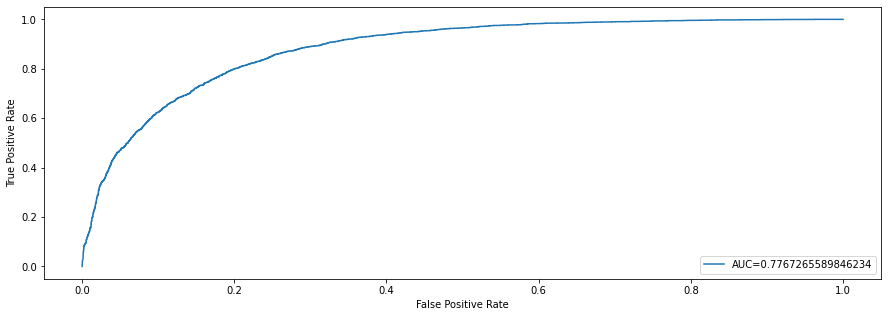

In [22]:
fpr, tpr, thresh = roc_curve(valid_labels_df['non-empty'],  valid_scores_df['non-empty'])
auc = roc_auc_score(valid_labels_df['non-empty'],  valid_preds_df['non-empty'])

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()